In [10]:
from importlib import reload
import wsj_dataset
from torch.utils.data import DataLoader, sampler
import utils
import gmm_spatial_clustering
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
reload(wsj_dataset)
reload(utils)
reload(gmm_spatial_clustering)
plt.style.use('classic')

folder = '/pipeline/data/wsj0-mix/2speakers_anechoic/wav8k/min/tr/'

In [331]:
from tqdm import trange
weight_sum = 0

bs_dataset = wsj_dataset.WSJ0(folder=folder,
                           n_fft=256,
                           hop_length=64,
                           output_type='spatial_bootstrap',
                           weight_method='confidence',
                           length=400,
                           take_left_channel=False,
                           num_channels=1,
                           cache_location='test_conf')
bs_dataset.create_cache = False


gt_dataset = wsj_dataset.WSJ0(folder=folder,
                           n_fft=256,
                           hop_length=64,
                           output_type='ibm',
                           weight_method='magnitude',
                           length=400,
                           take_left_channel=False,
                           num_channels=1,
                           cache_location='test_ibm')
gt_dataset.create_cache = False

gt1k_dataset = wsj_dataset.WSJ0(folder=folder,
                           n_fft=256,
                           hop_length=64,
                           output_type='ibm',
                           weight_method='magnitude',
                           length=400,
                           take_left_channel=False,
                           num_channels=1,
                           limit=1000,
                           cache_location='test_ibm')
gt1k_dataset.create_cache = False

In [323]:
def partition_distance(V, Y, W):
    V = np.sqrt(W)*V
    Y = np.sqrt(W)*Y
    VtV = np.linalg.inv(np.dot(V.T, V))
    YtY = np.linalg.inv(np.dot(Y.T, Y))
    VtY = np.dot(V.T, Y)
    YtV = np.dot(Y.T, V)
    tr = np.matrix.trace(np.dot(np.dot(VtV, VtY), np.dot(YtY, YtV))) 
    L = tr - 1
    L = L * np.sum(W)
    return L

def dc_distance(V, Y, W):
    V = np.sqrt(W)*V
    Y = np.sqrt(W)*Y
    VtV = np.linalg.norm(np.dot(V.T, V))**2
    YtY = np.linalg.norm(np.dot(Y.T, Y))**2
    VtY = np.linalg.norm(np.dot(V.T, Y))**2
    dist = VtV + YtY - 2*VtY
    return dist

In [340]:
_weights = 0
from tqdm import tnrange

for i in range(0, len(gt1k_dataset)):
    if i % 200 == 0:
        print(i)
    V = gt1k_dataset[i][-3].reshape(-1, V.shape[-1])
    W = gt1k_dataset[i][-2]
    W = W.reshape(-1, W.shape[-1]) ** 2
    Y = gt1k_dataset[i][-3].reshape(-1, V.shape[-1])
    
    Wb = gt1k_dataset[i][-2]
    Wb = Wb.reshape(-1, Wb.shape[-1]) ** 2
    Wb = np.expand_dims(Wb[:, 0], axis=-1)
    
    _Wb = Wb ** 0
    _Wb *= W
    #distances[alpha] += partition_distance(V, Y, _Wb)
    #dc_distances[alpha] += dc_distance(V, Y, _Wb)
    _weights += np.sum(_Wb)

0
200
400
600
800


In [335]:
weights

{4: 7411393546298.754}

In [336]:
distances = {}
dc_distances = {}
weights = {}
alphas = [0, .5, 1, 2, 4]
from tqdm import tnrange

for i in range(0, len(bs_dataset)):
    if i % 2000 == 0:
        print(i)
    V = bs_dataset[i][-3].reshape(-1, V.shape[-1])
    W = gt_dataset[i][-2]
    #W = W > np.percentile(W, 90)
    W = W.reshape(-1, W.shape[-1]) ** 2
    Y = gt_dataset[i][-3].reshape(-1, V.shape[-1])
    
    Wb = bs_dataset[i][-2]
    Wb = Wb.reshape(-1, Wb.shape[-1]) ** 2
    Wb = np.expand_dims(Wb[:, 0], axis=-1)
    
    for alpha in alphas:
        _Wb = Wb ** alpha
        _Wb *= W
        if alpha not in distances:
            distances[alpha] = 0
            weights[alpha] = 0
            dc_distances[alpha] = 0

        distances[alpha] += partition_distance(V, Y, _Wb)
        #dc_distances[alpha] += dc_distance(V, Y, _Wb)
        weights[alpha] += np.sum(_Wb)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000


In [337]:
summary = []
for alpha in alphas:
    quality = (distances[alpha] / weights[alpha])
    summary.append(quality)
    quantity = (weights[alpha] / weights[0])
    print('alpha = %.2f' % alpha, 
          dc_distances[alpha], 
          #weights[alpha],
          '\t',
          '%.4f\t' % quality,
          '%.4f' % quantity)

alpha = 0.00 0 	 0.3027	 1.0000
alpha = 0.50 0 	 0.3620	 0.2053
alpha = 1.00 0 	 0.3873	 0.0536
alpha = 2.00 0 	 0.4002	 0.0052
alpha = 4.00 0 	 0.3764	 0.0001


In [338]:
weights

{0: 1087416673.34237,
 0.5: 223256976.12188214,
 1: 58338529.515578225,
 2: 5707995.117926573,
 4: 119271.87862811841}

In [342]:
_weights / weights[0]

0.049790505178329905

In [329]:
(.05 * weights[0]) / weights[0]

0.05

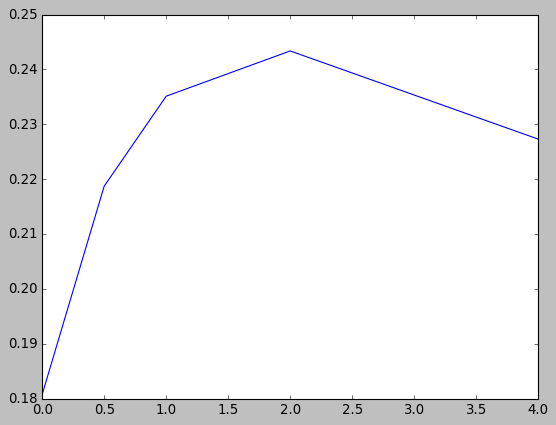

In [298]:
plt.plot(alphas, summary)

In [154]:
loss_gt /20000, loss_bs /20000

(0.3004026616123696, 0.3141017145759276)

In [132]:
W.shape

(51600, 2)

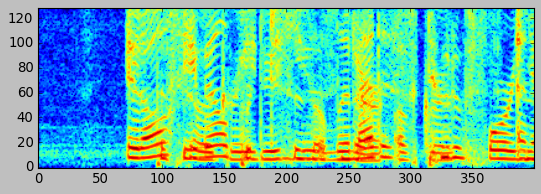

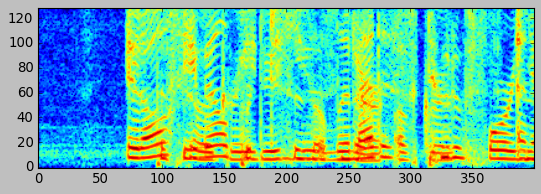

In [30]:
plt.imshow(bs_dataset[0][0][:, :, 0].T, origin='lower')
plt.show()

plt.imshow(gt_dataset[0][0][:, :, 0].T, origin='lower')
plt.show()